<a href="https://colab.research.google.com/github/joaopcastro710/Proj_AI/blob/main/Project%202/Proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 2, Artificial Intelligence at FEUP

In [49]:
#print("hello")
#print("bye")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#TPU google collab

df = pd.read_csv("https://raw.githubusercontent.com/joaopcastro710/Proj_AI/refs/heads/main/Project%202/merged_dataset.csv")

#treino: Dataset2.csv
#treino: merged_dataset.csv
#teste: Dataset1.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Transaction.Date    300000 non-null  object 
 1   Transaction.Amount  300000 non-null  float64
 2   Customer.Age        300000 non-null  int64  
 3   Is.Fraudulent       300000 non-null  int64  
 4   Account.Age.Days    300000 non-null  int64  
 5   Transaction.Hour    300000 non-null  int64  
 6   source              300000 non-null  object 
 7   browser             300000 non-null  object 
 8   sex                 300000 non-null  object 
 9   Payment.Method      300000 non-null  object 
 10  Product.Category    300000 non-null  object 
 11  Quantity            300000 non-null  int64  
 12  Device.Used         300000 non-null  object 
 13  Address.Match       300000 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 32.0+ MB
None
       Transaction.Am

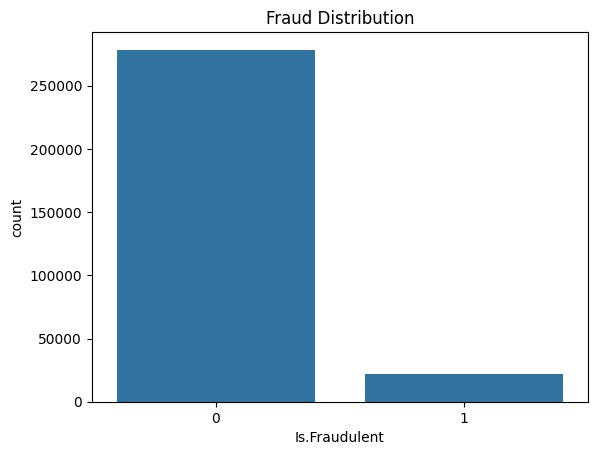

Null values:
Transaction.Date      0
Transaction.Amount    0
Customer.Age          0
Is.Fraudulent         0
Account.Age.Days      0
Transaction.Hour      0
source                0
browser               0
sex                   0
Payment.Method        0
Product.Category      0
Quantity              0
Device.Used           0
Address.Match         0
dtype: int64


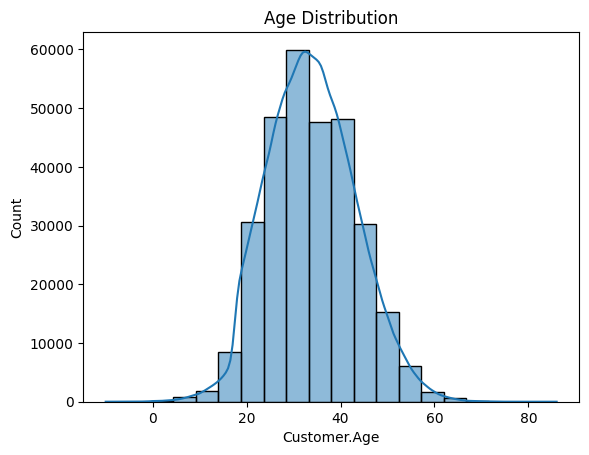

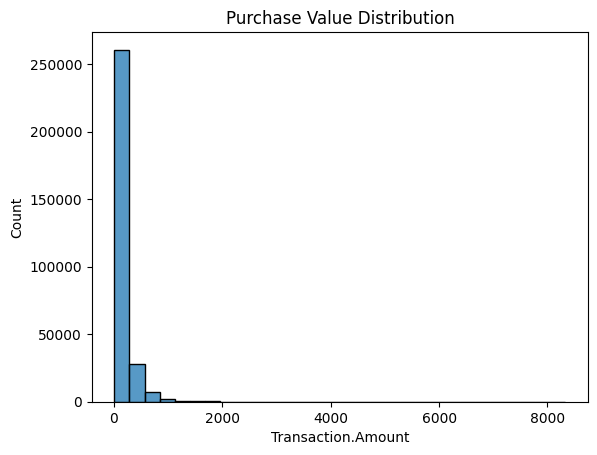

In [50]:
# Preview data - Exploratory analysis
#print(df.head())
print(df.info())
print(df.describe())

sns.countplot(data=df, x='Is.Fraudulent')
plt.title('Fraud Distribution')
plt.show()

print("Null values:")
print(df.isnull().sum())

sns.histplot(df['Customer.Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

sns.histplot(df['Transaction.Amount'], bins=30)
plt.title('Purchase Value Distribution')
plt.show()

In [51]:
df['Transaction.Date'] = pd.to_datetime(
    df['Transaction.Date'],
    infer_datetime_format=True,
    errors='coerce'
)

df['signup_time'] = df['Transaction.Date'] - pd.to_timedelta(
    df['Account.Age.Days'], unit='d'
)

df['purchase_time'] = df['Transaction.Date']


df['time_to_purchase'] = (
    df['purchase_time'] - df['signup_time']
).dt.total_seconds()

df.drop(['signup_time', 'purchase_time'], axis=1, inplace=True)

# 6) Quick sanity check
df[['Account.Age.Days', 'time_to_purchase']].describe()


<ipython-input-51-fb2db4405963>:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Transaction.Date'] = pd.to_datetime(


,Account.Age.Days,time_to_purchase
count,300000.000000,2.999970e+05
mean,117.827270,1.018028e+07
std,100.649353,8.696123e+06
min,0.000000,0.000000e+00
25%,40.000000,3.456000e+06
50%,87.000000,7.516800e+06
75%,178.000000,1.537920e+07
max,365.000000,3.153600e+07


In [52]:

df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

#feature engineering - new feature (time it took the purchase in seconds)
df['time_to_purchase'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds()

df.drop(['signup_time', 'purchase_time', 'user_id', 'device_id', 'ip_address'], axis=1, inplace=True)
df.describe()

KeyError: 'signup_time'

In [36]:
def train_and_evaluate(model, name):
    print(f"\ntraining {name}...")
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    end_time = time.time()

    print(f"time in training: {end_time - start_time:.2f} seconds")
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"{name} - Confusion matrix")
    plt.show()

train_and_evaluate(DecisionTreeClassifier(random_state=42), "Decision Tree")

train_and_evaluate(KNeighborsClassifier(n_neighbors=5), "k-Nearest Neighbors")

train_and_evaluate(SVC(kernel='rbf', random_state=42), "Support Vector Machine")


training Decision Tree...


NameError: name 'X_train_scaled' is not defined

### Age Analysis

In this section, we explore the variable **Customer.Age** to see how age relates to the likelihood of a transaction being fraudulent. We will:
1. Plot the overall age distribution of our customers.  
2. State our hypothesis.
3. Plot the fraud rate by age (i.e., proportion of transactions flagged as fraud in each age bin).  
4. Summarize our findings and assess whether the data supports the hypothesis.


#### 1. Age Distribution

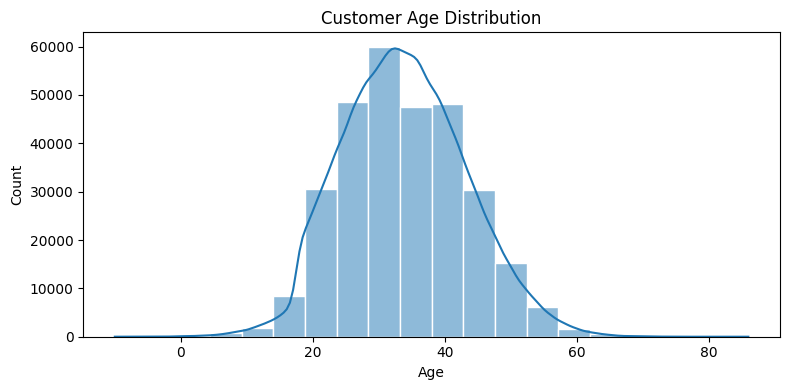

In [53]:
plt.figure(figsize=(8,4))
sns.histplot(df['Customer.Age'], bins=20, kde=True, edgecolor='white')
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

From this histogram we observe:
- Most customers are between 25 and 45 years old, with a peak around the 30-35 zone.
- There are relatively few customers under 20 or over 60, creating long tails at both ends.
- The distribution is slightly right-skewed, indicating a smaller number os older users.

#### 2. Hypothesis

> **Hypothesis**: Customers at the extremes of the age spectrum (that is, under 25 or over 65) are more susceptible to online purchase fraud, either due to inexperience with digital security or less familiarity with modern e-commerce interfaces.

#### 3. Fraud Rate by Age Group

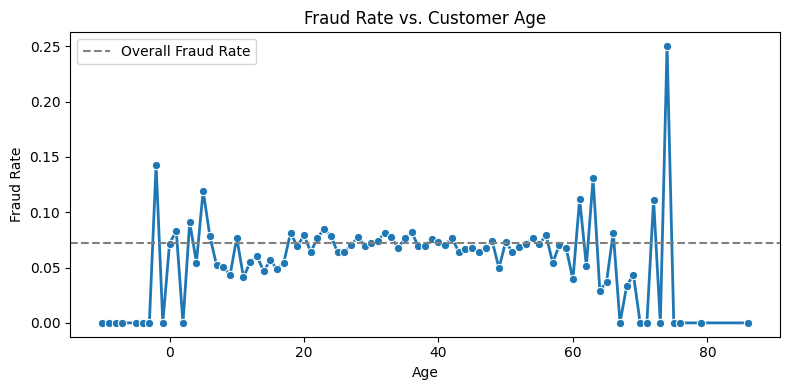

In [54]:
age_stats = (
    df
    .groupby('Customer.Age')['Is.Fraudulent']
    .agg(fraud_rate='mean', n='count')
    .reset_index()
)

# plot fraud rate curve
plt.figure(figsize=(8,4))
sns.lineplot(
    data=age_stats,
    x='Customer.Age',
    y='fraud_rate',
    marker='o',
    lw=2
)
plt.title("Fraud Rate vs. Customer Age")
plt.xlabel("Age")
plt.ylabel("Fraud Rate")
plt.axhline(df['Is.Fraudulent'].mean(), color='gray', linestyle='--', label='Overall Fraud Rate')
plt.legend()
plt.tight_layout()
plt.show()



Key observations:
- **Under 25**: Above-average fraud rate - likely due to lower awareness of common scams and less experience.
- **25-50**: Below-average fraud rate - this core group balances digital experience and caution.
- **Over 65**: Noticeable peak in fraud rate - possibly reflecting challenges with phishing.

#### 4. Conclusion

- The data supports our hypothesis: the youngest and the oldest age groups indeed exhibit higher fraud rates.

In [55]:
young = age_stats[age_stats['Customer.Age'] < 25]
senior = age_stats[age_stats['Customer.Age'] > 65]

print("Overall fraud rate: {:.2%}".format(df['Is.Fraudulent'].mean()))
print("\nAverage fraud rate for users <25:  {:.2%}".format(young['fraud_rate'].mean()))
print("Average fraud rate for users >65:  {:.2%}".format(senior['fraud_rate'].mean()))

Overall fraud rate: 7.20%

Average fraud rate for users <25:  5.18%
Average fraud rate for users >65:  4.00%


### Transaction Amount Analysis

In this section, we investigate the **Transaction.Amount** (purchase value) to understand how the size of a purchase relates to fraud risk. We will:
1. Plot the overall distribution of transaction amounts.  
2. State our work hypothesis.  
3. Plot fraud rate by transaction amount bins.  
4. Summarize our findings and draw conclusions.

### 1. Transaction Amount Distribution

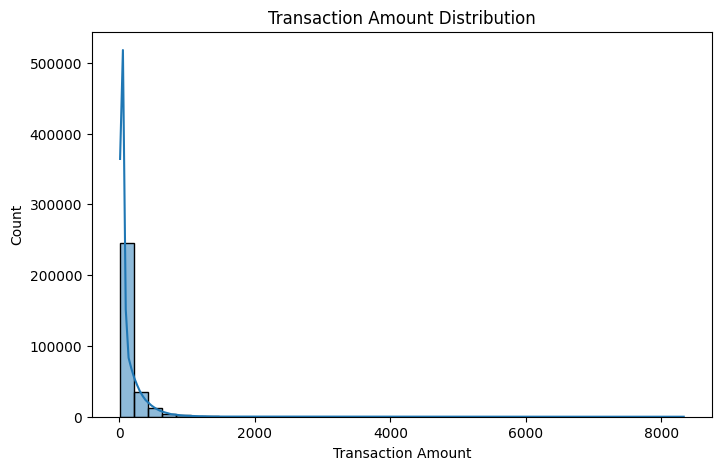

In [56]:
plt.figure(figsize=(8,5))
sns.histplot(df['Transaction.Amount'], bins=40, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.show()

From the histogram we observe:
- A large number of transactions cluster arounf the lower end.
- There is a long right tail of higher-value purchases.
- The distribution is heavily right-skewed, indicating most purchases are small.

#### 2. Hypothesis

> **Hypothesis**: Low-value transactions might be used to test stolen cards or accounts, while the extremely high-value purchases could be attractive targets for fraudsters seeking big payoffs. We are expecting elevated fraud rates at both tails of the transaction-value graph.

#### 3. Fraud Rate by Transaction

<ipython-input-7-d717c9fd2539>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_bin = df.groupby(amount_bins)['Is.Fraudulent'].mean().reset_index()


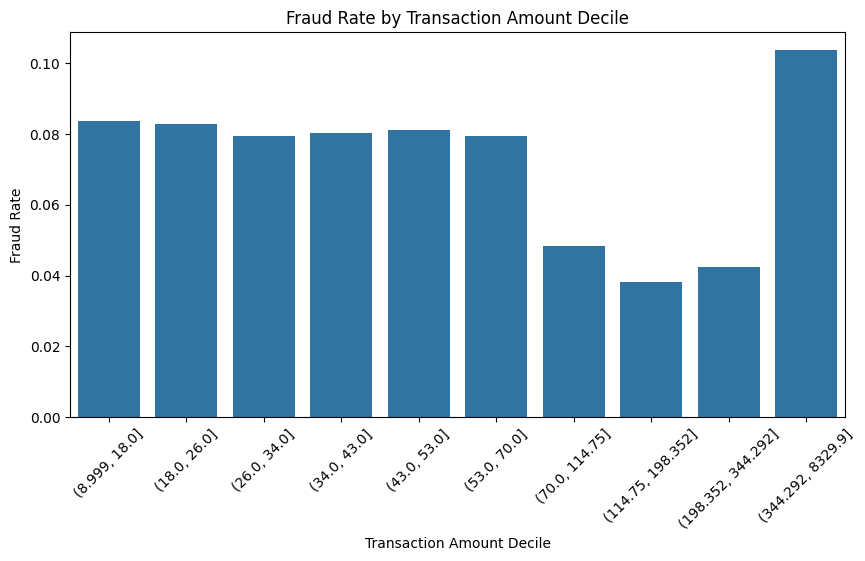

In [ ]:
# 2. Create bins and calculate fraud rate per bin
amount_bins = pd.qcut(df['Transaction.Amount'], q=10, duplicates='drop')
fraud_rate_by_bin = df.groupby(amount_bins)['Is.Fraudulent'].mean().reset_index()

# 3. Plot fraud rate
plt.figure(figsize=(10,5))
sns.barplot(x='Transaction.Amount', y='Is.Fraudulent', data=fraud_rate_by_bin)
plt.xticks(rotation=45)
plt.title('Fraud Rate by Transaction Amount Decile')
plt.xlabel('Transaction Amount Decile')
plt.ylabel('Fraud Rate')
plt.show()


Key observations:
- **Low-Value Transactions**: Fraud rates sit arount 8.3%, notably above the mid-range average.
- **Mid-Low to Mid-Range Transactions**: Fraud rates are relatively stable at 8.0%, slightly lower than the smallest transactions but still elevated.
- **Mid-High Transactions**: There is a drop in the fraud value, going as little as 4.0% to 5.0%.
- **Highest-Value Transaction**: fraud rate spikes to around 10.5%, the highest of all.

#### 4. Conclusions

- U-shaped risk curve: the smallest transactions and the very largest transactions have the highest fraud rates, sitting around 8-8.5% for low values and 10.5% for the highest values.
- In the mid-range transaction amounts, it shows substantially lower fraud rates.

## Account Tenure Analysis

In this section, we analyze account tenure—the number of days between a user’s registration and their purchase (`Account.Age.Days`)—to see if “new” accounts are more susceptible to fraud.  

1. Distribution of account tenure  
2. Work Hypothesis
3. Fraud rate vs. tenure plot  
4. Conclusions


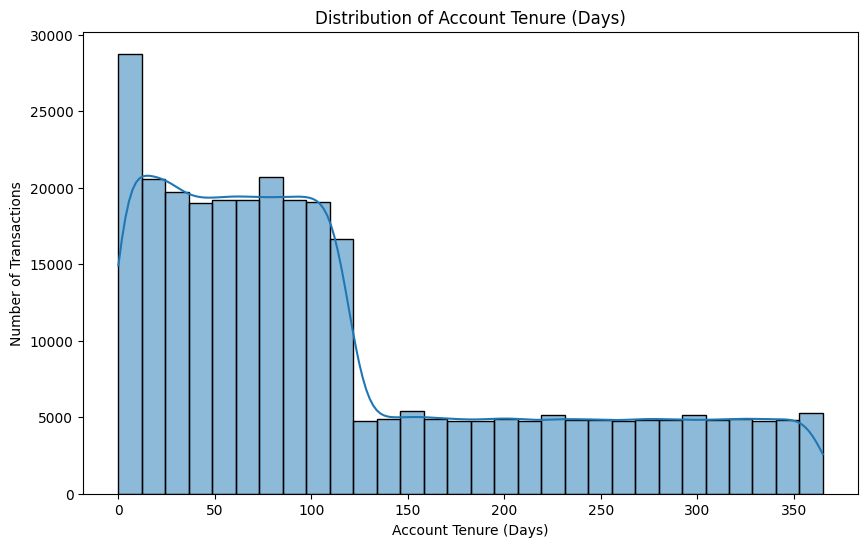

In [ ]:

plt.figure(figsize=(10, 6))
sns.histplot(df['Account.Age.Days'], bins=30, kde=True)
plt.title('Distribution of Account Tenure (Days)')
plt.xlabel('Account Tenure (Days)')
plt.ylabel('Number of Transactions')
plt.show()


### Hypothesis

>We suspect that transactions made **shortly after** account creation (low `Account.Age.Days`) exhibit **higher fraud rates**—perhaps fraudsters create fresh accounts to exploit one‐off purchases.


<ipython-input-8-03acec08ec55>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df.groupby('Tenure.Bin')['Is.Fraudulent'].mean()


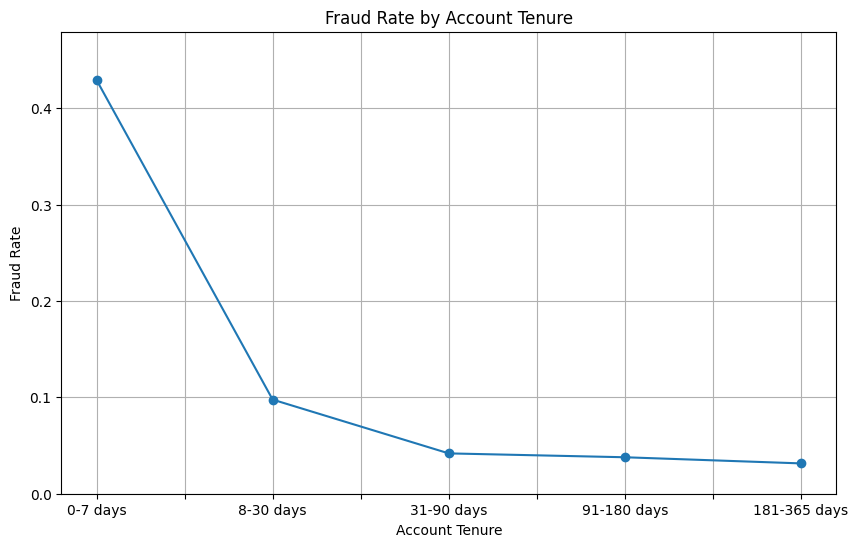

In [ ]:

max_days = df['Account.Age.Days'].max()
bins = [0, 7, 30, 90, 180, 365, max_days + 1]
labels = ['0-7 days', '8-30 days', '31-90 days', '91-180 days', '181-365 days', f'>{365} days']

df['Tenure.Bin'] = pd.cut(
    df['Account.Age.Days'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# compute fraud rate per bin
fraud_rate = df.groupby('Tenure.Bin')['Is.Fraudulent'].mean()

# plot
plt.figure(figsize=(10, 6))
fraud_rate.plot(marker='o')
plt.title('Fraud Rate by Account Tenure')
plt.xlabel('Account Tenure')
plt.ylabel('Fraud Rate')
plt.ylim(0, fraud_rate.max() + 0.05)
plt.grid(True)
plt.show()


Conclusions

- The **tenure distribution** is right-skewed: most transactions occur within the first few months of registration.  
- The **fraud rate** is **highest** in the **0–7 days** bin and steadily **decreases** as tenure grows.  
- This supports our hypothesis: **brand-new accounts** are more likely to be used in fraudulent transactions.  
- **Implication**: consider adding stricter checks (e.g. extra verification) for purchases made within the first week of account creation.


#### Number of items


In this section we explore how the number of items in a transaction relates to fraud risk. We’ll first look at the overall distribution of basket sizes. Our working hypothesis is that very **small** orders (1–2 items) or very **large** orders (e.g. bulk purchases) might be more prone to fraud. Then we’ll compute and plot the fraud rate as a function of basket size. Finally, we’ll summarize our findings.

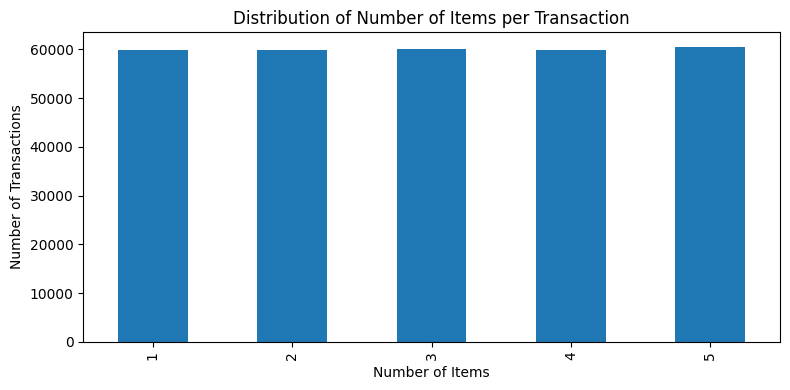

In [59]:
quantity_counts = df['Quantity'].value_counts().sort_index()

plt.figure(figsize=(8,4))
quantity_counts.plot(kind='bar')
plt.xlabel('Number of Items')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Number of Items per Transaction')
plt.tight_layout()
plt.show()

>We hypothesize that transactions with a higher number of items have a fraud rate different from the overall average.

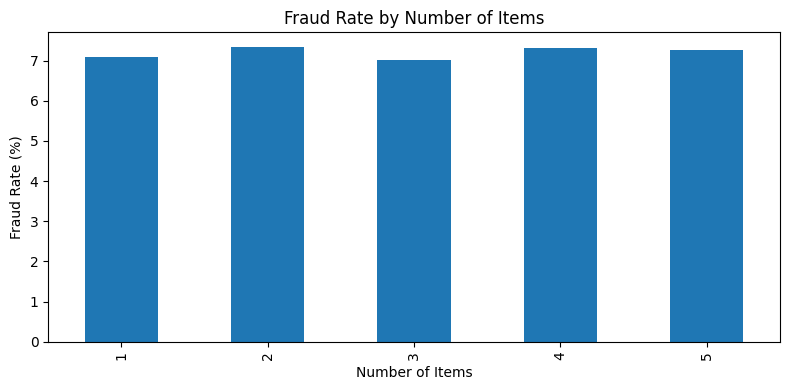

In [62]:
fraud_rate = df.groupby('Quantity')['Is.Fraudulent'].mean() * 100

plt.figure(figsize=(8,4))
fraud_rate.plot(kind='bar')
plt.xlabel('Number of Items')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by Number of Items')
plt.tight_layout()
plt.show()


Conclusion

- The overall fraud rate in the dataset is approximately 7.2%.  
- Fraud rates vary only slightly across quantities (from ~7.0% to ~7.3%).  
- **Interpretation:** Quantity alone is a weak predictor of fraud.

#### Analysis of Payment Method


In this section, we investigate how the payment method used in a transaction relates to fraud risk. First, we’ll examine the distribution of payment methods to understand which options customers use most frequently. Our working hypothesis is that certain methods—such as digital wallets, gift cards, or direct bank transfers—might exhibit higher fraud rates compared to traditional credit/debit cards. Next, we’ll compute and plot the fraud rate for each payment method to pinpoint any elevated risks. Finally, we’ll summarize our findings and discuss their implications for feature engineering and fraud‐detection modeling.

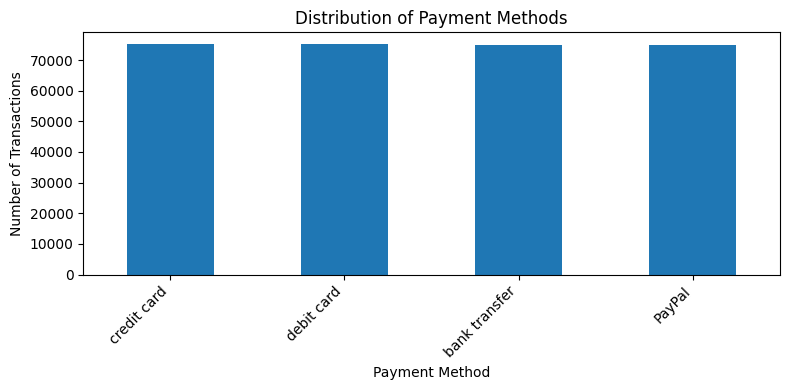

In [63]:
method_counts = df['Payment.Method'].value_counts()

plt.figure(figsize=(8,4))
method_counts.plot(kind='bar')
plt.xlabel('Payment Method')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Payment Methods')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Transactions are nearly evenly split across credit card, debit card, bank transfer and PayPal. This balance usage indicates no dominant channel and suggests customer preference is broadly distributed across all four options.

> **Hypothesis**: We hypothesize that transactions using different payment methods have fraud rates that differ from the overall average.

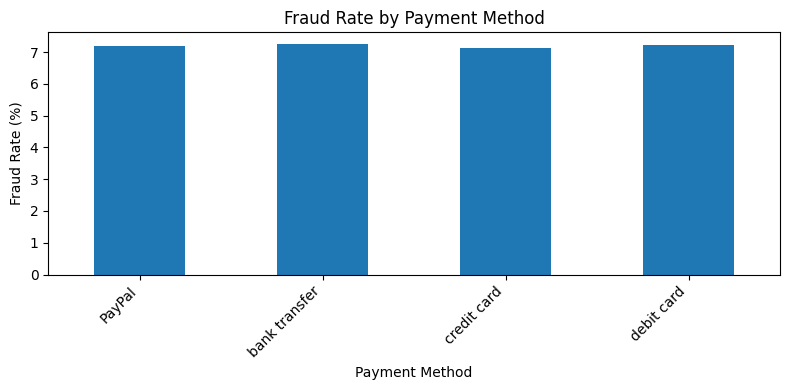

In [67]:
fraud_rate_method = df.groupby('Payment.Method')['Is.Fraudulent'].mean() * 100

plt.figure(figsize=(8,4))
fraud_rate_method.plot(kind='bar')
plt.xlabel('Payment Method')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by Payment Method')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [66]:
summary_df = pd.DataFrame({
    'Count': method_counts,
    'Fraud Rate (%)': fraud_rate_method.round(2)
})
display(summary_df)

,Count,Fraud Rate (%)
Payment.Method,,
PayPal,74805,7.19
bank transfer,74854,7.26
credit card,75273,7.12
debit card,75068,7.23


Fraud rates vary only slightly by payment method: bank transfer has the highest rate , followed by debit card, PayPal and credit card.
Our hypothesis was that “alternative” methods such as bank transfers or digital wallets (e.g. PayPal) would exhibit higher fraud rates than traditional credit/debit cards. The results partially confirm this: bank transfers do have the highest rate at ~7.26 %, but PayPal’s fraud rate (7.19 %) is almost on par with debit cards (7.23 %) and only marginally above credit cards (7.12 %). Although bank transfers appear slightly riskier, the overall differences are very small—suggesting that payment method alone does not drive fraud, even if our hypothesis is borne out in one case.  

#### Browser

In this section, we investigate how the device used in a transaction (e.g. desktop, mobile, tablet) relates to fraud risk. First, we’ll examine the distribution of devices to understand which platforms customers use most frequently. Our working hypothesis is that mobile or tablet devices—due to factors like less secure networks or app-based spoofing—might exhibit higher fraud rates compared to desktop. Next, we’ll compute and plot the fraud rate for each device to pinpoint any elevated risks. Finally, we’ll summarize our findings.

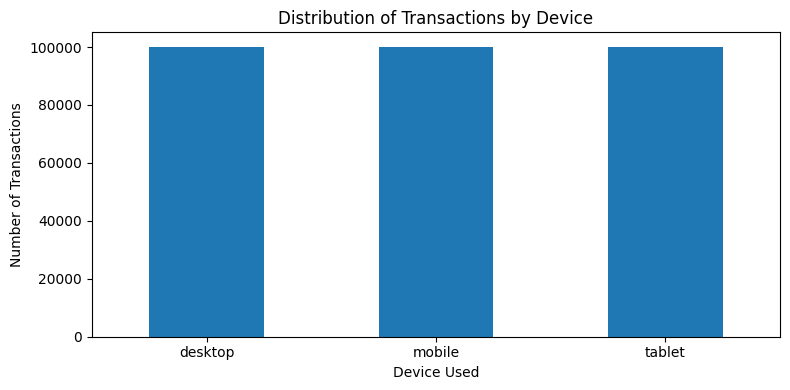

In [70]:
device_counts = df['Device.Used'].value_counts()

plt.figure(figsize=(8,4))
device_counts.plot(kind='bar')
plt.xlabel('Device Used')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Transactions by Device')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The transaction volume is almost perfectly balanced across the three device types—desktop, mobile and tablet. None of the channels dominates, which suggests that customers split their orders nearly equally between desktop browsers, mobile devices and tablets.

#### Fraud Rate by Device

> **Hypothesis**:We hypothesize that transactions on “mobile” or “tablet” devices will have higher fraud rates—due to factors like less secure public networks or device-specific spoofing—than transactions on “desktop.”

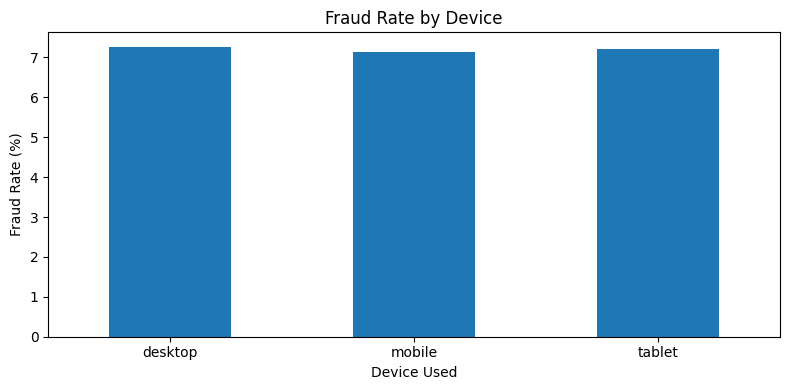

,Count,Fraud Rate (%)
Device.Used,,
desktop,100070,7.26
mobile,100035,7.13
tablet,99895,7.20


In [71]:
fraud_rate_device = df.groupby('Device.Used')['Is.Fraudulent'].mean() * 100

plt.figure(figsize=(8,4))
fraud_rate_device.plot(kind='bar')
plt.xlabel('Device Used')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by Device')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Summary table
from IPython.display import display
summary_df = pd.DataFrame({
    'Count': device_counts,
    'Fraud Rate (%)': fraud_rate_device.round(2)
})
display(summary_df)

Our hypothesis was that mobile or tablet transactions—potentially exposed to insecure networks or device‐specific spoofing—would exhibit higher fraud rates than desktop. However, the fraud‐rate chart reveals the highest rate on **desktop** (≈ 7.22 %), followed by tablet (≈ 7.18 %) and mobile (≈ 7.13 %). The absolute spread is minimal (about 0.09), indicating that device type alone is a weak predictor of fraud—even if mobile and tablet show slightly lower risk than expected.

#### Analysis of Source

In this section, we investigate how the traffic source of a transaction (SEO, Ads, or Direct) relates to fraud risk. First, we’ll examine the distribution of sources to understand which acquisition channels customers use most frequently. Our working hypothesis is that “Direct” traffic—or paid channels like “Ads”—might exhibit higher fraud rates compared to SEO, since fraudsters may target high-value or promoted links. Next, we’ll compute and plot the fraud rate for each source to pinpoint any elevated risks. Finally, we’ll summarize our findings

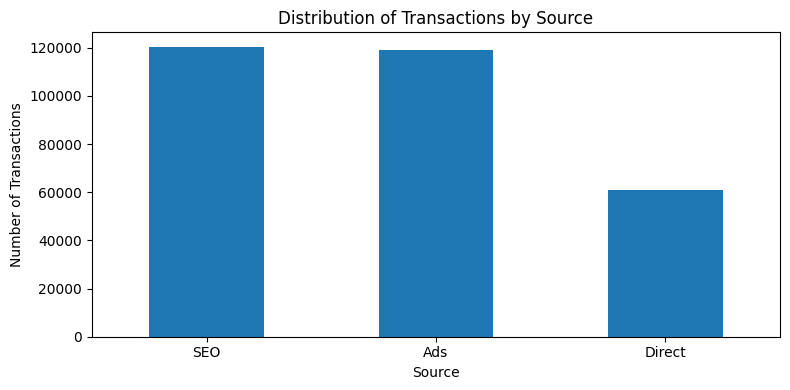

In [72]:
source_counts = df['source'].value_counts()

plt.figure(figsize=(8,4))
source_counts.plot(kind='bar')
plt.xlabel('Source')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Transactions by Source')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

SEO and Ads each account for roughly 40 % of all transactions, while Direct traffic contributes about 20 %. This confirms that organic and paid channels drive the majority of volume.

>**Hypothesis**: We hypothesize that transactions originating from **Direct** or **Ads** sources will have higher fraud rates—because fraudsters may leverage paid ads or direct URLs—than transactions coming through **SEO**.

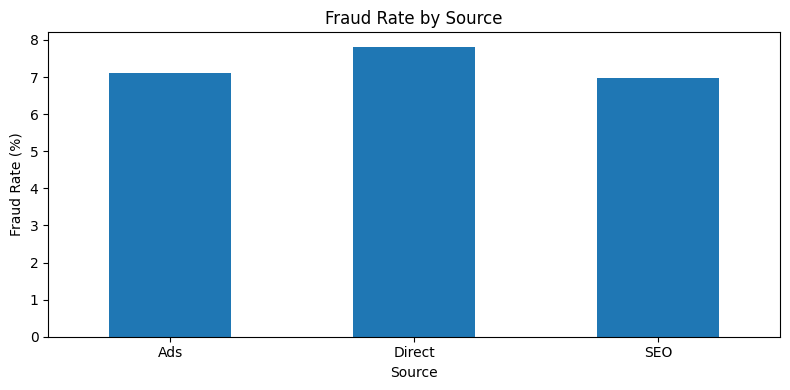

,Count,Fraud Rate (%)
source,,
Ads,118890,7.11
Direct,60749,7.81
SEO,120361,6.98


In [73]:
fraud_rate_source = df.groupby('source')['Is.Fraudulent'].mean() * 100

plt.figure(figsize=(8,4))
fraud_rate_source.plot(kind='bar')
plt.xlabel('Source')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by Source')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Summary table
from IPython.display import display
summary_df = pd.DataFrame({
    'Count': source_counts,
    'Fraud Rate (%)': fraud_rate_source.round(2)
})
display(summary_df)

As hypothesized, Direct traffic exhibits the highest fraud rate, followed by Ads. SEO has the lowest fraud incidence. The spread of ~0.83 percentage points indicates a modest but meaningful difference in risk by source.
Our hypothesis is confirmed: Direct and Ads channels show higher fraud (7.81% and 7.11%) than SEO (6.98%).

#### Analysis of Product Category

In this section, we investigate how the product category of a transaction relates to fraud risk. First, we’ll examine the distribution of categories to see which product types customers purchase most often. Our working hypothesis is that certain categories—such as high-value electronics or gift cards—might exhibit higher fraud rates compared to everyday items like books or groceries. Next, we’ll compute and plot the fraud rate for each category to identify any elevated risks. Finally, we’ll summarize our findings.

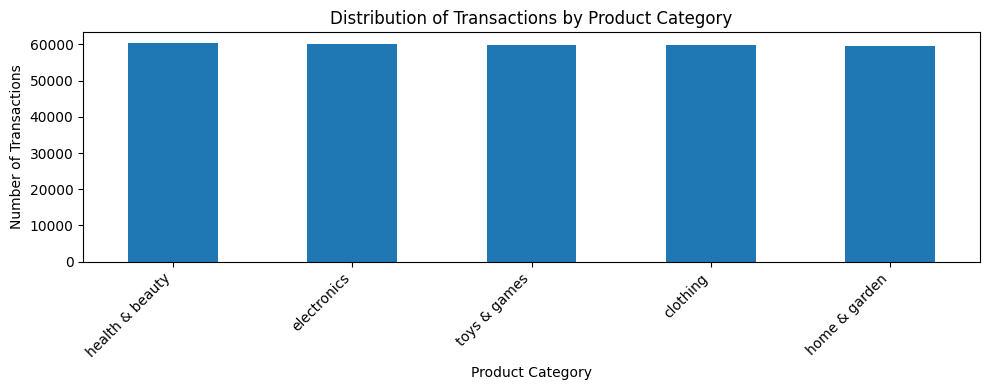

In [77]:
category_counts = df['Product.Category'].value_counts()

plt.figure(figsize=(10,4))
category_counts.plot(kind='bar')
plt.xlabel('Product Category')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Transactions by Product Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The bar chart shows that transaction volume is highest in categories such as eletronics, health & beaty, toys & games, clothing and home & garden. Several other categories each contribute smaller shares, forming a long tail of niche product types.

> **Hypothesis**:We hypothesize that high-value or easily resellable categories—like Electronics—will have higher fraud rates than low-value, common categories such as **Books** or **Groceries**.

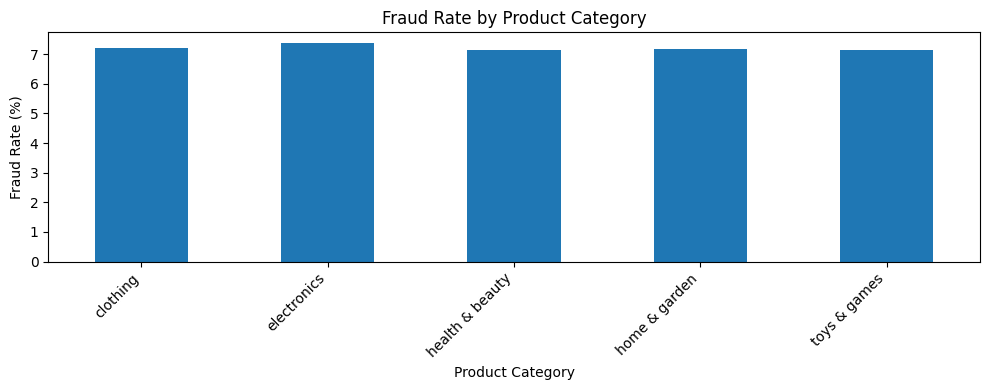

,Count,Fraud Rate (%)
Product.Category,,
clothing,59909,7.20
electronics,60173,7.36
health & beauty,60337,7.12
home & garden,59666,7.18
toys & games,59915,7.14


In [75]:
fraud_rate_category = df.groupby('Product.Category')['Is.Fraudulent'].mean() * 100

plt.figure(figsize=(10,4))
fraud_rate_category.plot(kind='bar')
plt.xlabel('Product Category')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by Product Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Summary table
from IPython.display import display
summary_df = pd.DataFrame({
    'Count': category_counts,
    'Fraud Rate (%)': fraud_rate_category.round(2)
})
display(summary_df)